# 28회 ADP 복원 

packages

In [258]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display , HTML
display(HTML("<style>.container {width :95% !important;}</style>"))

from scipy.stats import chi2_contingency
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , classification_report

import warnings 
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier


import time
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu
import pingouin as pg

# 기계학습 (50점)

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/dipam7/student-grade-prediction?resource=download 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv
- 데이터 설명 : 학생의 다양한 주변 환경에 따른 결석 등급 (absences)
    - sex : 성별 (F : 여성 / M :남성)
    - age : 나이
    - pstatus : 부모와 동거 유무 (T : 동거중 , A : 별거)
    - medu : 어머니 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5~9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - fedu : 아버지 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5 - 9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - guardian : 학생의 보호자
    - traveltime : 집에서 학교까지 이동 시간(1 - <15분, 2 - 15 - 30분, 3 - 30분 - 1시간, 또는 4 - >1시간)
    - studytime : 주간 학습 시간(1 - <2시간, 2 - 2 - 5시간, 3 - 5 - 10시간 또는 4 - >10시간)
    - failures : 과거 클래스 실패 수(n if 1<=n<3, 그렇지 않으면 4)
    - freetime : 방과 후 자유 시간(숫자: 1 - 매우 낮음에서 5 - 매우 높음)
    - famrel : 가족 관계의 질(숫자: 1 - 매우 나쁨에서 5 - 훌륭함)
    - absences : 학교 결석 횟수등급 (0~5, 높은 숫자일수록 많은 결석 횟수)

In [14]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv")
df.head()

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,F,18,A,4,4,mother,2,2,0,3,4,2
1,F,17,T,1,1,father,1,2,0,3,5,1
2,F,15,T,1,1,mother,1,2,3,3,4,3
3,F,15,T,4,2,mother,1,3,0,2,3,0
4,F,16,T,3,3,father,1,2,0,3,4,1


## 1-1. EDA를 진행하고 (+시각화) , 차원축소의 필요성이 있는지 확인 (5점)

컬럼명,sex,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel
카이제곱 독립성검정 p-value,0.793048,0.019316,0.451756,0.673619,0.015805,0.834993,0.044393,0.005994,0.483288,0.840443


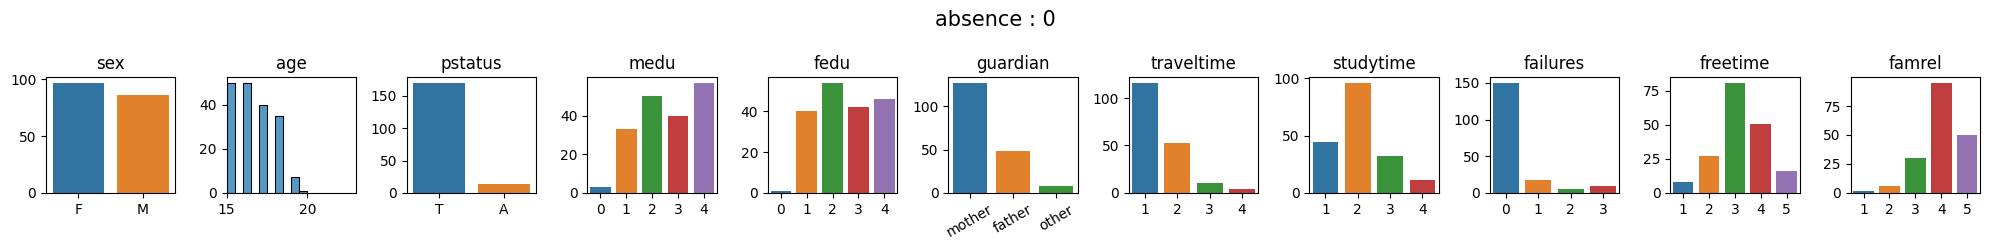

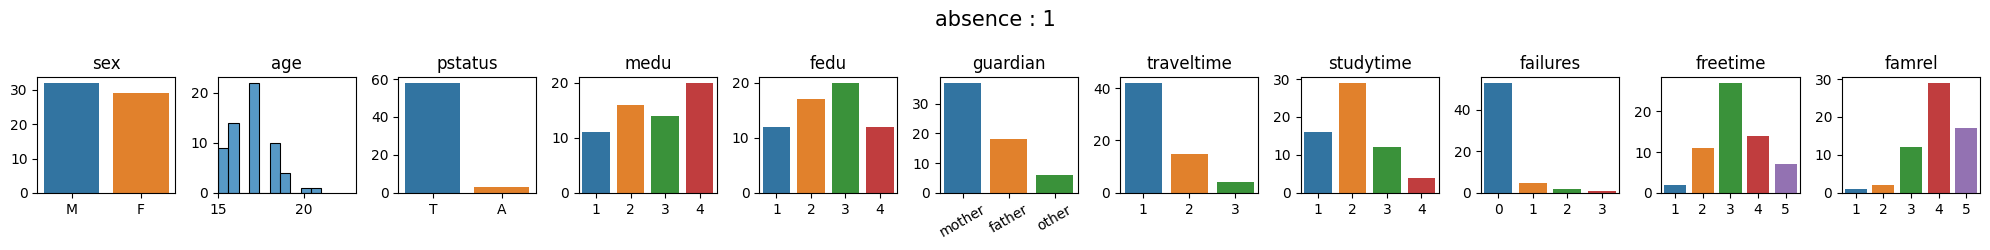

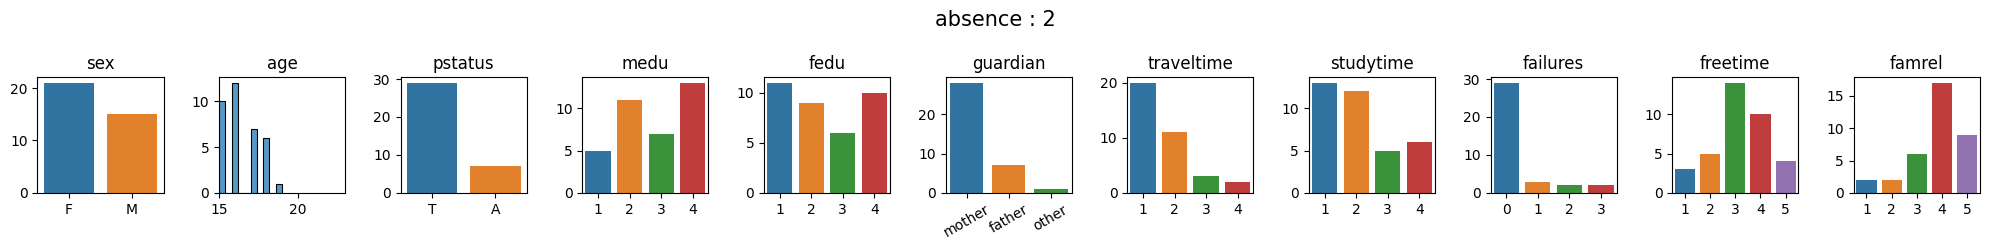

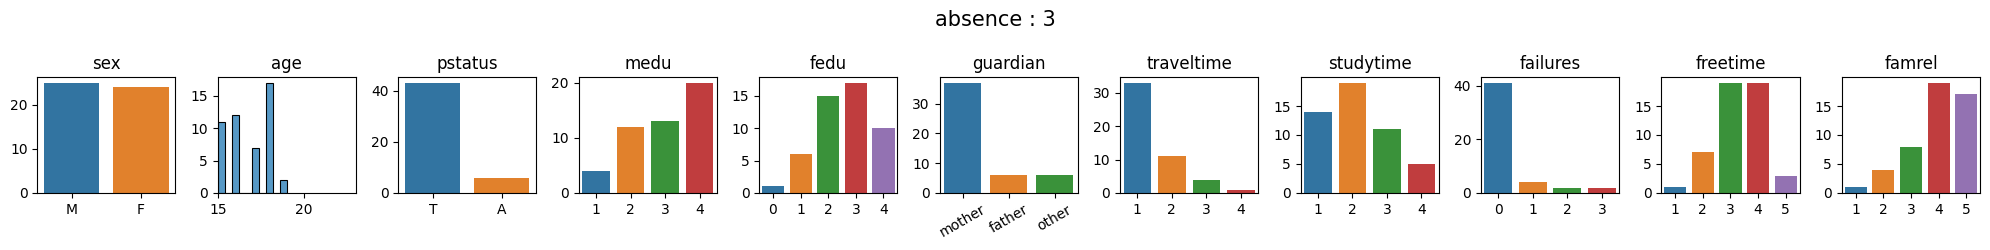

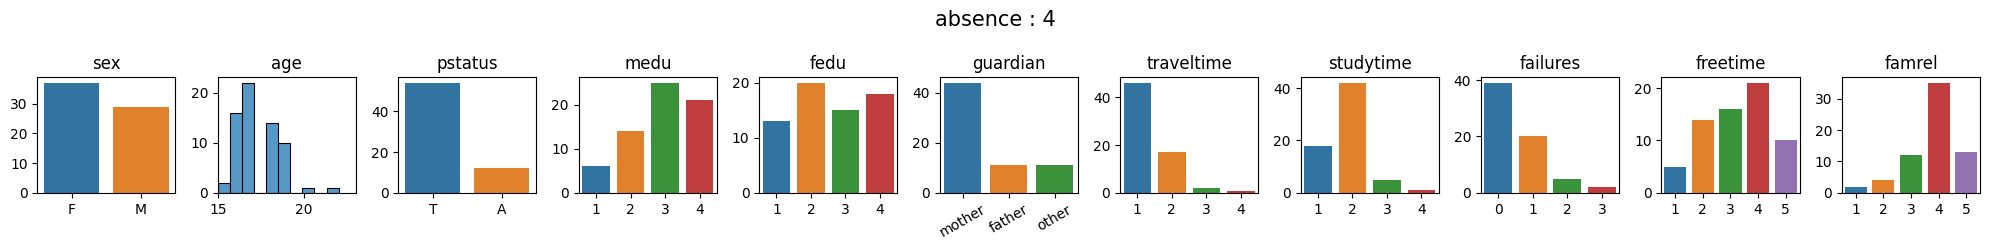

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13
분산설명력,0.209782,0.190134,0.130152,0.106455,0.069152,0.055187,0.052656,0.043011,0.039200,0.035506,0.030513,0.020161,0.018092
누적합,0.209782,0.399916,0.530068,0.636523,0.705675,0.760862,0.813518,0.856529,0.895728,0.931234,0.961747,0.981908,1.000000



답안
위 그래프는 absence의 값에 따른 각 컬럼의 데이터 분포를 나타낸다. 각 컬럼의 유니크 값의 개수는 레이블에 따라 시각적으로는 눈에 띄는 차이를 보이지 않는다.
연속형 변수인 age컬럼을 제외하고 각컬럼들을 absences와 카이제곱 독립성 검정을 했을 때, pstatus,guardian,studytime,failures 컬럼에서
유의수준 0.05하에서 변수간에 유의한 관계를 가짐을 알 수 있다.
범주형 변수 중 string형식으로 된 변수들을 더미변수 처리하고 minmax스케일링 후 pca를 진행했다. 분산설명력이 7개컬럼은 있어야 80%를 넘는다.
데이터 숫자도 작고 주성분들의 분산설명력이 그다지 높지 않기 떄문에 차원축소의 필요성이 떨어진다고 볼 수 있다.



In [15]:
lst = [] 
for col in df.columns[:-1]:
    
    if col != 'age':
        cross_tab_df = pd.crosstab(df[col],df['absences'])
        chi2, p, dof, expected = chi2_contingency(cross_tab_df)
        lst.append([col,p])
    
display(pd.DataFrame(lst,columns =['컬럼명','카이제곱 독립성검정 p-value']).set_index('컬럼명').T)

n_plt_columns = len(df.columns) -1 # absences 컬럼 제외
for absences in sorted(df['absences'].unique()):
    
    fig,axes = plt.subplots(1,n_plt_columns,figsize=(20,2.5))
    
    for col , ax in zip(df.columns[:-1],axes.flat):
        
        target_df = df.query(f"absences =='{absences}'")[col]
        if col =='age':
            sns.histplot(target_df,ax=ax,bins=10)
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title(col)
            ax.set_xlim(df[col].min(),df[col].max()+1)

        else:
            df_value_counts =target_df.value_counts().to_frame()
            sns.barplot(x = df_value_counts.index , y = df_value_counts[col],ax=ax)
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_title(col)
            
            if col =='guardian':
                ax.set_xticklabels( df_value_counts.index, rotation=30)
                
    plt.suptitle(f"absence : {absences}",fontsize=15)
    fig.tight_layout()
    plt.show()
    

pca = PCA()
df_dummies = pd.get_dummies(df,drop_first=True)
pca_df_scaled = MinMaxScaler().fit_transform(df_dummies)

pca.fit(pca_df_scaled)
pca_ex_v = pd.DataFrame(pca.explained_variance_ratio_,columns =['분산설명력'])
pca_ex_v['누적합'] = pca_ex_v['분산설명력'].cumsum()
pca_ex_v.index = ['pc_'+str(i+1) for i in range(len(pca_ex_v))]
display(pca_ex_v.T)

print('''
답안\n위 그래프는 absence의 값에 따른 각 컬럼의 데이터 분포를 나타낸다. 각 컬럼의 유니크 값의 개수는 레이블에 따라 시각적으로는 눈에 띄는 차이를 보이지 않는다.
연속형 변수인 age컬럼을 제외하고 각컬럼들을 absences와 카이제곱 독립성 검정을 했을 때, pstatus,guardian,studytime,failures 컬럼에서
유의수준 0.05하에서 변수간에 유의한 관계를 가짐을 알 수 있다.
범주형 변수 중 string형식으로 된 변수들을 더미변수 처리하고 minmax스케일링 후 pca를 진행했다. 분산설명력이 7개컬럼은 있어야 80%를 넘는다.
데이터 숫자도 작고 주성분들의 분산설명력이 그다지 높지 않기 떄문에 차원축소의 필요성이 떨어진다고 볼 수 있다.
''')

## 1-2. 데이터 품질 개선을 위한 방법이 있는지 찾고 데이터셋을 재생성하라 (5점)

In [42]:
x = df_dummies.drop(columns =['absences'])
y = df_dummies['absences']

smote = SMOTE(random_state =1)
x_resample, y_resample = smote.fit_resample(x,y)

t = pd.concat([y.value_counts().sort_index(),y_resample.value_counts().sort_index()],axis=1)
t.columns =['기존 샘플수','smote 후 샘플수']
t.index.name ='라벨'
display(t.T)
print('''
종속변수의 데이터 불균형이 있다. 이를 해결하기 위해 smote방식을 이용하여 오버샘플링을 진행한다.
''')

라벨,0,1,2,3,4
기존 샘플수,183,61,36,49,66
smote 후 샘플수,183,183,183,183,183



종속변수의 데이터 불균형이 있다. 이를 해결하기 위해 smote방식을 이용하여 오버샘플링을 진행한다.



## 1-3. 1.2에서 제시한 방법이 데이터 과적합이 된다는 가정하에 어떻게 해결할 수 있을지 2가지 개선안 제시, 각방법들의 장단점 기술 (10점)

In [17]:
print('''
방법1\n 스케일링을 다양하게 시도하며 오버 샘플링을 진행한다. 데이터 특성을 반영할 수 있기에 장점이 된다. 
방법2\n 과적합 되는 레이블에 대해서 오버 샘플링 된 데이터들의 숫자를 조절한다. 
''')


방법1
 스케일링을 다양하게 시도하며 오버 샘플링을 진행한다. 데이터 특성을 반영할 수 있기에 장점이 된다. 
방법2
 과적합 되는 레이블에 대해서 오버 샘플링 된 데이터들의 숫자를 조절한다. 



## 2-1. 1-2 데이터셋을 기준으로 random forest, neural network , lightgbm 3가지 방식으로 학교 결석 횟수등급을 예측하는 모델을 만들어라, f1 score로 모델을 평가하라 (5점)

In [84]:
rf = RandomForestClassifier(random_state=1)
nn = MLPClassifier(random_state=1)
lgbm =LGBMClassifier(random_state=1)

x_train,x_test,y_train,y_test = train_test_split(x_resample,y_resample,random_state=1,test_size=0.3)

rf.fit(x_train,y_train)
nn.fit(x_train,y_train)
lgbm.fit(x_train,y_train,verbose=2)

rf_pred = rf.predict(x_test)
nn_pred = nn.predict(x_test)
lgbm_pred = lgbm.predict(x_test)

def f1_filter(y_test,y_pred,name):
    macro = f1_score(y_test,y_pred,average='macro')
    micro = f1_score(y_test,y_pred,average='micro')
    weighted = f1_score(y_test,y_pred,average='weighted')
    
    return pd.DataFrame([macro,micro,weighted],columns =[name],index=['macro','micro','weighted'])


rf_f1 = f1_filter(y_test,rf_pred,'랜덤포레스트')
nn_f1 = f1_filter(y_test,nn_pred,'뉴럴넷')
lgbm_f1 = f1_filter(y_test,lgbm_pred,'lightgbm')

t = pd.concat([rf_f1,nn_f1,lgbm_f1],axis=1)
t.index.name = 'f1_score'
display(t)

print('''
train,test셋의 비율을 7:3으로 하고 3개 모델에 대해 각각 학습하고 f1 score를 나타난 결과이다.
다중분류의 경우 f1 score는 3가지 방식(macro , micro ,weighted)으로 평가할 수 있다.
f1 score는 최대 1의 값을 가지기에 3가지 모델 모두 낮은 예측력을 가진다고 볼 수 있다.
랜덤포레스트와 lgbm의 경우 뉴럴넷에 비해 높은 f1 score를 보이는데 앙상블 방식의 모델이
스케일링 하지 않은 데이터에 대해서도 좋은 성능을 보이기 때문이다.
3가지 방식에 대한 평가 점수간의 차이가 크지 않은 이유는 smote를 통해 클래스간 분포가 큰 차이가 없기 때문이다.
클래스 간 불균형이 심한 경우 micro방식은 작은 클래스의 성능이 무시될 수 있고, micro방식은 큰 클래스가 평균에 미치는 영향이 더 크게 나타날 수 있으며
weighted방식은 작은 클래스의 성능이 무시될 수 있다.
''')

,랜덤포레스트,뉴럴넷,lightgbm
f1_score,,,
macro,0.660427,0.391428,0.601677
micro,0.669091,0.396364,0.603636
weighted,0.660421,0.389350,0.601308



train,test셋의 비율을 7:3으로 하고 3개 모델에 대해 각각 학습하고 f1 score를 나타난 결과이다.
다중분류의 경우 f1 score는 3가지 방식(macro , micro ,weighted)으로 평가할 수 있다.
f1 score는 최대 1의 값을 가지기에 3가지 모델 모두 낮은 예측력을 가진다고 볼 수 있다.
랜덤포레스트와 lgbm의 경우 뉴럴넷에 비해 높은 f1 score를 보이는데 앙상블 방식의 모델이
스케일링 하지 않은 데이터에 대해서도 좋은 성능을 보이기 때문이다.
3가지 방식에 대한 평가 점수간의 차이가 크지 않은 이유는 smote를 통해 클래스간 분포가 큰 차이가 없기 때문이다.
클래스 간 불균형이 심한 경우 micro방식은 작은 클래스의 성능이 무시될 수 있고, micro방식은 큰 클래스가 평균에 미치는 영향이 더 크게 나타날 수 있으며
weighted방식은 작은 클래스의 성능이 무시될 수 있다.



## 2-2. hard voting, soft voting에 대한 장단점을 설명하고 2-1의 3가지 모델로 구현하라. 두 방식의 f1-score를 비교하라 (10점)

In [85]:
rf_v = RandomForestClassifier(random_state=1)
nn_v = MLPClassifier(random_state=1)
lgbm_v =LGBMClassifier(random_state=1)

soft_v = VotingClassifier(estimators=[('rf', rf_v), ('nn', nn_v), ('lgbm', lgbm_v)], voting='soft')
hard_v = VotingClassifier(estimators=[('rf', rf_v), ('nn', nn_v), ('lgbm', lgbm_v)], voting='hard')

hard_v.fit(x_train,y_train)
soft_v.fit(x_train,y_train)

hard_v_pred = hard_v.predict(x_test)
soft_v_pred = soft_v.predict(x_test)


def f1_filter(y_test,y_pred,name):
    macro = f1_score(y_test,y_pred,average='macro')
    micro = f1_score(y_test,y_pred,average='micro')
    weighted = f1_score(y_test,y_pred,average='weighted')
    return pd.DataFrame([macro,micro,weighted],columns =[name],index=['macro','micro','weighted'])


soft_v1 = f1_filter(y_test,hard_v_pred,'hard_voting')
hard_v1 = f1_filter(y_test,soft_v_pred,'soft_voting')

t = pd.concat([soft_v1,hard_v1],axis=1)
t.index.name = 'f1_score'
display(t)

print('''
하드보팅과 소프트 보팅방식으로 f1 score를 계산했을 때 결과를 보여준다 개별모델들 중 최고 성능을 낸 랜덤포레스트 보다는 예측력이 낮지만
좀 더 일반화가 가능하다는 장점이 있다. 하드보팅보다는 확률 평균 방식의 소프트보팅이 f1 score가 높게 나왔다.
두 방식 모두 앙상블 방법으로 성능향상과 모델 일반화를 기대할 수 있다.
하드보팅은 모델들의 결과에 대한 다수결로 최종 예측을 하고 소프트보팅은 개별 모델의 예측확률에 대해 가중평균을 내서 최종 예측을 수행한다.
하드보팅은 직관적이고 간단한 장점이 있지만 성능을 높이는데 한계가 존재한다. 
소프트보팅의 방식의 경우 개별모델의 확률정보를 반영한다는 장점이 있다. 단점은 예측 방식이 확률을 내뱉지 않은 모델을 사용할 수 없다는 점이 있다.
''')

,hard_voting,soft_voting
f1_score,,
macro,0.616554,0.645347
micro,0.614545,0.647273
weighted,0.616537,0.645180



하드보팅과 소프트 보팅방식으로 f1 score를 계산했을 때 결과를 보여준다 개별모델들 중 최고 성능을 낸 랜덤포레스트 보다는 예측력이 낮지만
좀 더 일반화가 가능하다는 장점이 있다. 하드보팅보다는 확률 평균 방식의 소프트보팅이 f1 score가 높게 나왔다.
두 방식 모두 앙상블 방법으로 성능향상과 모델 일반화를 기대할 수 있다.
하드보팅은 모델들의 결과에 대한 다수결로 최종 예측을 하고 소프트보팅은 개별 모델의 예측확률에 대해 가중평균을 내서 최종 예측을 수행한다.
하드보팅은 직관적이고 간단한 장점이 있지만 성능을 높이는데 한계가 존재한다. 
소프트보팅의 방식의 경우 개별모델의 확률정보를 반영한다는 장점이 있다. 단점은 예측 방식이 확률을 내뱉지 않은 모델을 사용할 수 없다는 점이 있다.



## 2-3. 총 5개 모델(RF, NN, LGBM, 하드보팅, 소프트보팅) 중 실시간 온라인 시스템에 가장 적합한 모델과 선정이유를 객관적으로 제시하라 (5점)

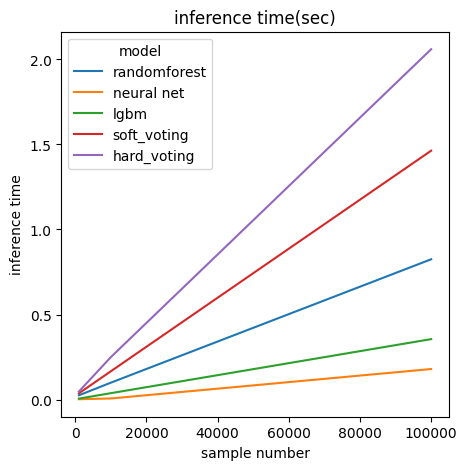


아래 그래프는 샘플수에 따른 각 모델별 모델추론 시간에 대한 그래프이다. 모델 수에 따라
추론시간이 선형적으로 증가하는 것을 확인 할 수 있다. 실시간 온라인 시스템에서 관심을 가지는것이
성능인지 빠른 추론시간인지에 따라 선택 방향이 달라질 것 이다.
보팅 방식의 경우 3가지 모델을 모두 추론해야하기 때문에 그 시간이 선형 합으로 증가한다.
성능의 경우 랜덤포레스트가 가장 좋았지만 추론시간이 lgbm보다 3배이상 크다.
시스템의 핵심 요구사항에 따라 랜덤포레스트와 lgbm중에 선택하는 것이 옳다



In [117]:
def sample_generate(n):
    sp =x_resample.sample(n,replace=True)
    return sp


def count_predict_times(model,data):
    
    start = time.time()
    model.predict(data)
    end = time.time()
    
    inference_time = end - start
    return inference_time

lst = []
for model,name in [(rf,'randomforest'),(nn,'neural net'),(lgbm,'lgbm'),(soft_v,'soft_voting'),(hard_v,'hard_voting')]:
    for sample_number in [1000,10000,100000]:
        inference_time = count_predict_times(model,sample_generate(sample_number))
        lst.append([name,sample_number,inference_time])
        
t= pd.DataFrame(lst,columns =['model','sample number','inference time'])
tp = t.pivot_table(index='model',columns ='sample number',values ='inference time')

fig,ax = plt.subplots(1,figsize=(5,5))
sns.lineplot(data =t , x = 'sample number',y= 'inference time',hue='model',ax=ax)
plt.title('inference time(sec)')
plt.show()
print('''
아래 그래프는 샘플수에 따른 각 모델별 모델추론 시간에 대한 그래프이다. 모델 수에 따라
추론시간이 선형적으로 증가하는 것을 확인 할 수 있다. 실시간 온라인 시스템에서 관심을 가지는것이
성능인지 빠른 추론시간인지에 따라 선택 방향이 달라질 것 이다.
보팅 방식의 경우 3가지 모델을 모두 추론해야하기 때문에 그 시간이 선형 합으로 증가한다.
성능의 경우 랜덤포레스트가 가장 좋았지만 추론시간이 lgbm보다 3배이상 크다.
시스템의 핵심 요구사항에 따라 랜덤포레스트와 lgbm중에 선택하는 것이 옳다
''')

## 3-1. 적정 모델과 선정 및 모델링 과정에서 추가적으로 고려해볼 만한 사항은? (5점)

모델을 api 형식으로 제공할때 모델의 용량에 따라 추론시간 및 유지비용이 달라 질 수 있다.     
큰 용량의 모델이라면 백앤드 시스템에서 모델을 import 하고 유지 하는데 비용이 달라진다.       
프로젝트의 규모와 자원등을 고려하여 적합한 모델을 설계한다.     

## 3-2. 모델을 학교 시스템에 적용하여 활용하려한다. 모델 적용 및 운영과정에서 고려해볼 만한 사항? (5점)

데이터가 누적됨에 따라 모델을 업데이트 해야하는 경우가 생길 수 있다. 새롭게 저장될 데이터 인프라를 잘 갖춰 긴밀한 업데이트를 해주는게    
모델 정확도를 높히는데 도움이 될 수 있다. 또한 covid상황과 같은 기존 모델의 상황에서는 학습하지 못한 상황이 오는 경우     
모델 효용이 떨어질 수 있다. 이런 경우에는 서비스를 중단하고 대응 모델을 적용할 수 있도록 서비스 구조를 만들어야 할 것 이다.     

# 통계 (50점)

# 4번 데이터
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv
- status : 생존 여부 (death: 죽음 / event lost: 생존)
- company : 회사구분

In [122]:
import pandas as pd 
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv')
df.head()

,time(month),status,company
0,1,event lost,X
1,2,event lost,X
2,3,event lost,X
3,4,event lost,X
4,5,event lost,X


## 4-1 Kaplan Meier 방법 사용 생존분석 수행. 회사부품별 25, 35, 45 개월에서의 생존 확률 (소숫점 3자리 ,5점)

In [192]:
df['status_map'] = df['status'].map({'event lost':0,'death':1})

x = df[df.company =='X'].reset_index(drop=True)
y = df[df.company =='Y'].reset_index(drop=True)

kmf_x = KaplanMeierFitter()
kmf_x.fit(x[x.columns[0]], event_observed=x['status_map'])
x_pred = kmf_x.predict([25,35,45])


kmf_y = KaplanMeierFitter()
kmf_y.fit(y[y.columns[0]], event_observed=y['status_map'])
y_pred = kmf_y.predict([25,35,45])


t =pd.concat([x_pred,y_pred],axis=1).round(3)
t.index.name = 'month'
t.columns =['X company','Y company']
display(t)

print('''
status컬럼의 데이터를 가변수 처리(죽음:1) 한 후 패키지를 이용하여 25,35,45개월에서의 생존확률을 구한다
''')

,X company,Y company
month,,
25,0.636,0.88
35,0.636,0.88
45,0.636,0.88



status컬럼의 데이터를 가변수 처리(죽음:1) 한 후 패키지를 이용하여 25,35,45개월에서의 생존확률을 구한다



## 4-2 두 회사간 생존시간 차이를 log-rank 방식으로 검정하시오. 가설설정, 통계량, 귀무가설 기각여부 판단(10점)

In [204]:
results = logrank_test(x[x.columns[0]], y[y.columns[0]],\
                       event_observed_A=x['status_map'], event_observed_B=y['status_map'])

display(results.summary)
print('''
log-rank 검정의 귀무가설은 '두 회사의 생존확률은 동일하다'이고 대립가설은 '두 회사의 생존확률은 다르다'이다.
통계량과 p-value는 다음과 같으며 유의수준 0.05하에서 귀무가설을 기각할 수 없다. 그러므로 두 회사의 생존확률은 동일하다라고 보는게 유의하다.
''')

,test_statistic,p,-log2(p)
0,0.2,0.654721,0.611048



log-rank 검정의 귀무가설은 '두 회사의 생존확률은 동일하다'이고 대립가설은 '두 회사의 생존확률은 다르다'이다.
통계량과 p-value는 다음과 같으며 유의수준 0.05하에서 귀무가설을 기각할 수 없다. 그러므로 두 회사의 생존확률은 동일하다라고 보는게 유의하다.



# 5번 데이터
- 데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv 
- data형식
    - 한 유저가 시식 전 물건 구매의사 유,무와 시식 후 구매의사 유,무에 대한 응답을 나타낸 데이터
    - {시식전} _ {구매의사 유 or 무} __ {시식후} _ {구매의사 유 or 무}


In [233]:
import pandas as pd 
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv')
df.head()

,data,userId
0,시식전_유__시식후_유,user_1
1,시식전_유__시식후_유,user_2
2,시식전_유__시식후_유,user_3
3,시식전_유__시식후_유,user_4
4,시식전_유__시식후_유,user_5


## 5-1 시식여부가 구매의사에 영향을 주는지 가설을 설정하시오(5점)

2x2 범주형 변수이고 시점의 차이를 확인해야하므로 맥네마 검정을 이용한다    
귀무가설은 '두 시점 간에는 유의한 차이가 없다.' 이며     
대립가설은 '두 시점 간의 관찰된 빈도의 차이는 유의한 차이가 있다.' 이다.     

## 5-2 검정하고 결과를 분석하시오(5점)

In [241]:
df['시식전'] = df['data'].str.split('__').str[0].str.split('_').str[1].map({'유':'구매함','무':'구매안함'})
df['시식후'] = df['data'].str.split('__').str[1].str.split('_').str[1].map({'유':'구매함','무':'구매안함'})

r = pd.crosstab(df['시식전'],df['시식후'])
s,p,d,e = chi2_contingency(r, correction=False)

print(f'맥네마 검정 결과 통계량은 {s}, p-value는 {p}이다. 유의 수준 0.05하에서 귀무가설을 기각하지 못한다.')
print('두 시점간의 관찰된 빈도의 차이는 유의한 차이가 없다.')

맥네마 검정 결과 통계량은 1.6351501668520578, p-value는 0.2009921853884114이다. 유의 수준 0.05하에서 귀무가설을 기각하지 못한다.
두 시점간의 관찰된 빈도의 차이는 유의한 차이가 없다.


# 6번 데이터
- 데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv 

## 6-1 A,B 지역 학생의 점수에 차이가 있는지 가설을 설정하고 정하시오 (10점)

In [242]:
import pandas as pd 
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv')
df.head()

,score,school_name,ID
0,91.0,A,1
1,NaN,A,2
2,NaN,A,3
3,NaN,A,4
4,NaN,A,5


In [250]:
statistic, p_value = mannwhitneyu(df.dropna().query('school_name =="A"')['score'], df.dropna().query('school_name =="B"')['score'])

print('답안\nscore결측치를 제거하면 유효데이터는 총 28개이다. 비모수 방식의 맨 휘트니 U검정 방식을 통해 확인한다.')
print('귀무가설은 "두 그룹간의 차이가 없다" 이며 대립가설은 "두 그룹간의 차이가 존재한다."이다')
print(f'검정 결과 검정 통계량은 {statistic} , p-value는 {p_value}이다. 유의수준 0.05하에 귀무가설을 기각하지 못한다. 즉 두 그룹간의 차이는 없다')

답안
score결측치를 제거하면 유효데이터는 총 28개이다. 비모수 방식의 맨 휘트니 U검정 방식을 통해 확인한다.
귀무가설은 "두 그룹간의 차이가 없다" 이며 대립가설은 "두 그룹간의 차이가 존재한다."이다
검정 결과 검정 통계량은 58.0 , p-value는 0.13048990112711467이다. 유의수준 0.05하에 귀무가설을 기각하지 못한다. 즉 두 그룹간의 차이는 없다


# 7번 데이터
- 데이터 출처 : https://www.kaggle.com/datasets/hangawqadir/erbil-heart-disease-dataset
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv
- 연령, 몸무게,콜레스테롤 수치 데이터

In [260]:
import pandas as pd 
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv')
df.head()

,age,Cholesterol,weight
0,65,69.0,111.0
1,54,117.0,81.0
2,61,86.2,72.0
3,57,76.0,78.0
4,62,160.0,61.0


## 7-1 몸무게를 제어한다고 생각하고,  나이와 콜레스테롤 상관계수 및 유의확률 구하라(10점)

In [275]:
result = pg.partial_corr(data=df, x='age', y='Cholesterol', covar='weight')
display(result)

print(f'몸무게를 제어하는 경우 나이와 콜레스테롤의 상관계수는 {round(result.r.values[0],3)}이다.')
print(f'유의 확률(p-value)는 {round(result[result.columns[-1]].values[0],3)}이다.')

,n,r,CI95%,p-val
pearson,333,-0.134317,"[-0.24, -0.03]",0.014316


몸무게를 제어하는 경우 나이와 콜레스테롤의 상관계수는 -0.134이다.
유의 확률(p-value)는 0.014이다.


## 7-2 상관계수를 유의수준 0.05하에서 검정하라 (5점)

In [276]:
print('답안\n귀무가설은 두 변수 간의 편상관계가 0이다 이며 대립가설은 두 변수 간의 편상관계가 0이 아니다. 즉 편상관관계가 있다 이다.')
print(f'검정 결과 p-value는 {round(result[result.columns[-1]].values[0],3)}이다. 유의수준 0.05하에서 귀무가설을 기각하고 편상관관계가 있다라고 본다.')

답안
귀무가설은 두 변수 간의 편상관계가 0이다 이며 대립가설은 두 변수 간의 편상관계가 0이 아니다. 즉 편상관관계가 있다 이다.
검정 결과 p-value는 0.014이다. 유의수준 0.05하에서 귀무가설을 기각하고 편상관관계가 있다라고 본다.


끝. 7페이지